In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import os
import random
import keras_tuner as kt

from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# pd.set_option('display.max_rows', None)

In [3]:
insurance_df = pd.read_csv("Insurance_claims.csv")
insurance_df.head()

,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,InsurerNotes,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,ClaimInvolvedCovers,...,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud
0,4842,531112,715507.0,NaN,avoids a cat and hits a garage pole With deduc...,CivilServant,1/2/19,6/18/18,CollisionWithAnimal,MaterialDamages ActLiability,...,1,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,0
1,4844,87170,71164.0,NaN,accident only expert contacts us to inform us ...,Worker,1/2/19,6/29/17,LossOfControl,MaterialDamages ActLiability,...,3,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0
2,4848,98706,442609.0,NaN,ae Miss/ for garage change A/ setting up EAD/ ...,Worker,1/2/19,2/5/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability,...,9,93.0,0.25,0,998.20,18.0,32.0,0,0.5,0
3,4849,38240,24604.0,NaN,"awaiting report to determine rc, no box checke...",CivilServant,1/2/19,1/21/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability ReplacementVehicle,...,2,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,0
4,4850,11339,2933.0,229134.0,Insured in THIRD-PARTY formula Insured in a su...,Farmer,1/2/19,1/13/18,AccidentWithIdentifiedThirdParty,ActLiability,...,4,110.0,0.25,0,12.00,12.0,28.0,0,0.0,0


### For Q1, you need to describe the hit rate and detection rate metrics and their trade-off, and evaluate a model with given rates in monetary terms. Consider the following:

Hit Rate (Conversion Rate): Measures the model's effectiveness in identifying true fraud cases among the cases it flags. It's the ratio of true positives to the total flagged cases.

Detection Rate: Measures the model's ability to identify fraud cases from the entire dataset. It's the ratio of true positives to the total actual fraud cases.

Trade-off: Focusing solely on increasing the hit rate might decrease the detection rate as the model becomes too conservative, flagging only high-confidence cases. Conversely, aiming to increase the detection rate might decrease the hit rate as the model flags more cases, including more false positives.

Monetary Evaluation: Evaluate a model by considering the costs and savings involved. This includes the cost of false positives (incorrectly flagged cases), the cost of missed frauds (false negatives), the cost of investigating true positives, and the fixed capacity of investigation departments. Balancing these costs against the savings from identifying frauds gives a monetary value to the model's performance.

Remember to account for the fixed capacity of the investigation department, meaning that the investigation cost doesn't linearly increase with the number of flagged cases but is limited to the department's capacity. This affects the trade-off between the hit rate and detection rate and should be factored into the cost computation.

In [4]:
insurance_df.isna().sum().sort_values()

ReferenceId                            0
NumberOfBodilyInjuries                 0
ClaimAmount                            0
ClaimWihoutIdentifiedThirdParty        0
EasinessToStage                        0
NumberOfPoliciesOfPolicyholder         0
PolicyWasSubscribedOnInternet          0
PolicyHolderPostCode                   0
FirstPartyLiability                    0
Fraud                                  0
FirstPolicySubscriptionDate            0
LossDate                               0
PolicyholderNumber                     0
FirstPartyVehicleType                 12
FpVehicleAgeMonths                    12
PolicyHolderAge                       36
LossHour                              94
ClaimInvolvedCovers                  195
ClaimCause                           197
PolicyholderOccupation               343
FirstPartyVehicleNumber              495
LossPostCode                        1408
InsurerNotes                        2357
DamageImportance                   10792
ThirdPartyVehicl

In [5]:
insurance_df['FpVehicleAgeMonths'].mode()

0    144.0
Name: FpVehicleAgeMonths, dtype: float64

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

insurance_df = pd.read_csv("Insurance_claims.csv")
# Sample data
text_data = insurance_df['InsurerNotes'].fillna("nonSpecified")  # replace 'text_column_name' with your actual column name

# Create the transform
vectorizer = TfidfVectorizer(max_features=500, min_df=5, max_df=0.7, stop_words='english')

# Tokenize and build vocab
X_tfidf = vectorizer.fit_transform(text_data)

# Convert the result to a dense DataFrame
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names())
insurance_df = pd.concat([insurance_df.drop(columns=['InsurerNotes']), df_tfidf], axis=1)
insurance_df

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,ClaimInvolvedCovers,DamageImportance,...,xxx,xxxe,xxxth,xxxx,xxxxx,xxxxxxx,xxxxxxxxxx,xxy,yes,yesterday
0,4842,531112,715507.0,NaN,CivilServant,1/2/19,6/18/18,CollisionWithAnimal,MaterialDamages ActLiability,NaN,...,0.184112,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,4844,87170,71164.0,NaN,Worker,1/2/19,6/29/17,LossOfControl,MaterialDamages ActLiability,NaN,...,0.102880,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,4848,98706,442609.0,NaN,Worker,1/2/19,2/5/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability,NaN,...,0.145594,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,4849,38240,24604.0,NaN,CivilServant,1/2/19,1/21/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability ReplacementVehicle,NaN,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,4850,11339,2933.0,229134.0,Farmer,1/2/19,1/13/18,AccidentWithIdentifiedThirdParty,ActLiability,NaN,...,0.000000,0.0,0.0,0.053154,0.0,0.095282,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11525,16378,452486,626487.0,NaN,Employee,2/17/21,3/15/19,WindscreenDamage,Windscreen,NaN,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
11526,16379,581104,788178.0,NaN,Employee,3/7/21,7/20/17,WindscreenDamage,Windscreen,NaN,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
11527,16380,817231,NaN,NaN,Employee,3/15/21,9/30/20,WindscreenDamage,Windscreen,NaN,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
11528,16381,321534,468522.0,NaN,CivilServant,3/6/21,12/28/18,WindscreenDamage,Windscreen,NaN,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [7]:
# insurance_df = pd.read_csv("Insurance_claims.csv")

insurance_df = insurance_df.drop(
    columns=["ReferenceId", "PolicyholderNumber"]
)

insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])

insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])
insurance_df["FirstPolicySubscriptionDate"] = pd.to_datetime(insurance_df["FirstPolicySubscriptionDate"])

# calculate the number of days between the two dates
insurance_df["days_between"] = insurance_df.apply(
    lambda row: (row["LossDate"] - row["FirstPolicySubscriptionDate"]).days, axis=1
)

insurance_df = insurance_df.drop(columns=["LossDate", "FirstPolicySubscriptionDate"])

# Convert the columns to integer type
insurance_df['LossPostCode'] = pd.to_numeric(insurance_df['LossPostCode'], errors='coerce')
insurance_df['PolicyHolderPostCode'] = pd.to_numeric(insurance_df['PolicyHolderPostCode'], errors='coerce')

insurance_df['FirstPartyVehicleNumber_DupCount'] = insurance_df['FirstPartyVehicleNumber'].transform(lambda x: x.map(x.value_counts()))
insurance_df['FirstPartyVehicleNumber_DupCount'] = insurance_df['FirstPartyVehicleNumber_DupCount'].fillna(0)
insurance_df["FirstPartyVehicleNumber"] = insurance_df["FirstPartyVehicleNumber"].fillna(0)

insurance_df['ThirdPartyVehicleNumber_DupCount'] = insurance_df['ThirdPartyVehicleNumber'].transform(lambda x: x.map(x.value_counts()))
insurance_df["ThirdPartyVehicleNumber_DupCount"] = insurance_df["ThirdPartyVehicleNumber_DupCount"].fillna(0)
insurance_df["ThirdPartyVehicleNumber"] = insurance_df["ThirdPartyVehicleNumber"].fillna(0)


insurance_df['PolicyholderOccupation'] = insurance_df['PolicyholderOccupation'].fillna('nonSpecified')
insurance_df['ClaimCause'] = insurance_df['ClaimCause'].fillna('nonSpecified')
insurance_df['ClaimInvolvedCovers'] = insurance_df['ClaimInvolvedCovers'].fillna('nonSpecified')
insurance_df["DamageImportance"] = insurance_df["DamageImportance"].fillna('nonSpecified')
insurance_df['FirstPartyVehicleType'] = insurance_df['FirstPartyVehicleType'].fillna('nonSpecified')
insurance_df['ConnectionBetweenParties'] = insurance_df['ConnectionBetweenParties'].fillna('nonSpecified')
insurance_df["LossPostCode"] = insurance_df["LossPostCode"].fillna(0)
insurance_df['EasinessToStage'] = insurance_df['EasinessToStage'].fillna(insurance_df['EasinessToStage'].mean())
insurance_df['FpVehicleAgeMonths'] = insurance_df['FpVehicleAgeMonths'].fillna(insurance_df['FpVehicleAgeMonths'].mode()[0])
insurance_df['LossHour'] = insurance_df['LossHour'].fillna(insurance_df['LossHour'].mean())
insurance_df['PolicyHolderAge'] = insurance_df['PolicyHolderAge'].fillna(insurance_df['PolicyHolderAge'].mean())
insurance_df['PolicyHolderPostCode'] = insurance_df['PolicyHolderPostCode'].fillna(insurance_df['PolicyHolderPostCode'].mode()[0])


# check the two postcodes
def compare_digits(x, y):
    x_len = len(str(x))
    y_len = len(str(y))
    if x_len == y_len:
        if x_len == 5:
            return str(x)[:2] == str(y)[:2]
        elif x_len == 4:
            return str(x)[0] == str(y)[0]
        else:
            return False
    else:
        return False


# check if the loss place is in the same district of the holder's place
insurance_df["IfinSameArea"] = insurance_df.apply(
    lambda row: 1
    if compare_digits(row["LossPostCode"], row["PolicyHolderPostCode"])
    else 0,
    axis=1,
)

/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_56048/2663634525.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])
/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_56048/2663634525.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  insurance_df["FirstPolicySubscriptionDate"] = pd.to_datetime(insurance_df["FirstPolicySubscriptionDate"])


In [8]:
insurance_df.isna().sum()

FirstPartyVehicleNumber             0
ThirdPartyVehicleNumber             0
PolicyholderOccupation              0
ClaimCause                          0
ClaimInvolvedCovers                 0
                                   ..
yesterday                           0
days_between                        0
FirstPartyVehicleNumber_DupCount    0
ThirdPartyVehicleNumber_DupCount    0
IfinSameArea                        0
Length: 525, dtype: int64

In [9]:
object_columns = insurance_df.select_dtypes(include=['object']).columns.tolist()
object_columns

['PolicyholderOccupation',
 'ClaimCause',
 'ClaimInvolvedCovers',
 'DamageImportance',
 'FirstPartyVehicleType',
 'ConnectionBetweenParties']

In [10]:
# Perform one-hot encoding
# set these columns to dummies
insurance_df = pd.get_dummies(
    insurance_df,
    columns=object_columns,
    dtype='int32'
)

In [11]:
insurance_df.head()

,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,LossPostCode,PolicyHolderPostCode,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,...,FirstPartyVehicleType_Caravan,FirstPartyVehicleType_Motorcycle,FirstPartyVehicleType_PrivateCar,FirstPartyVehicleType_nonSpecified,ConnectionBetweenParties_SameAddress,ConnectionBetweenParties_SameBankAccount,ConnectionBetweenParties_SameEmail,ConnectionBetweenParties_SamePhone,ConnectionBetweenParties_SamePolice,ConnectionBetweenParties_nonSpecified
0,715507.0,0.0,31330.0,31330.0,1,1,104.0,0.25,1,4624.73,...,0,0,0,0,0,0,0,0,0,1
1,71164.0,0.0,29810.0,29200.0,0,3,230.0,0.50,1,1606.81,...,0,0,0,0,0,0,0,0,0,1
2,442609.0,0.0,33500.0,33500.0,0,9,93.0,0.25,0,998.20,...,0,0,0,0,0,0,0,0,0,1
3,24604.0,0.0,35310.0,35310.0,0,2,56.0,0.25,0,2506.92,...,0,0,0,0,0,0,0,0,0,1
4,2933.0,229134.0,29600.0,22000.0,0,4,110.0,0.25,0,12.00,...,0,0,0,0,0,0,0,0,0,1


In [12]:
insurance_df.Fraud.value_counts()

Fraud
0    11415
1      115
Name: count, dtype: int64

In [9]:
insurance_df.to_csv('test2_NoNLP.csv')

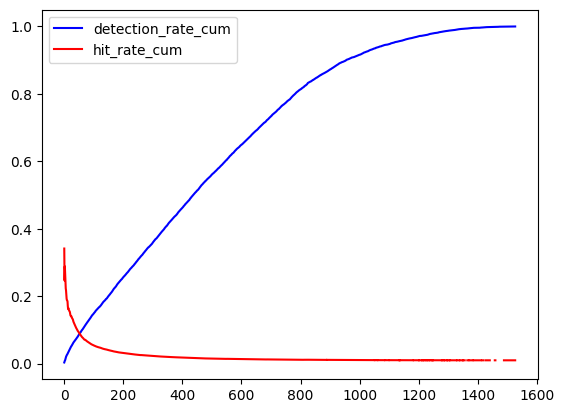

In [10]:
import numpy as np
import matplotlib.pyplot as plt

detection = insurance_df.groupby(['days_between']).size().reset_index(name='count')
detection.loc[:, "count_cum"] = detection['count'].cumsum()
detection.loc[:, "detection_rate_cum"] =  detection[['count_cum']]/len(insurance_df)
detection.loc[:, "fraud_cum"]  = insurance_df.groupby(['days_between'])[['Fraud']].sum().cumsum()
detection.loc[:, "hit_rate_cum"] = detection['fraud_cum']/detection['count_cum']


x = detection['days_between']
f = detection['detection_rate_cum']
g = detection['hit_rate_cum']

plt.plot(x, f, "-b", label="detection_rate_cum")
plt.plot(x, g, "-r", label="hit_rate_cum")
plt.legend(loc="upper left")

plt.show()

In [13]:
y = insurance_df["Fraud"]  # creating the dependent variable
X = insurance_df.drop(columns=["Fraud"])


X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, train_size=0.8, random_state=111
)

# X_test, X_valid, Y_test, Y_valid = train_test_split(
#     X_other, Y_other, test_size=0.5, random_state=111
# )

print(Y_test.value_counts())

smote = SMOTE(random_state=111, sampling_strategy=0.3)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)


# Checking the shapes of the datasets
print("Shapes of datasets:")
print("X_train (before SMOTE):", X_train.shape)
print("Y_train (before SMOTE):", Y_train.shape)
print("X_train (after SMOTE):", X_train_smote.shape)
print("Y_train (after SMOTE):", Y_train_smote.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


Fraud
0    2281
1      25
Name: count, dtype: int64
Shapes of datasets:
X_train (before SMOTE): (9224, 632)
Y_train (before SMOTE): (9224,)
X_train (after SMOTE): (11874, 632)
Y_train (after SMOTE): (11874,)
X_test: (2306, 632)
Y_test: (2306,)


In [13]:
Y_train_smote.value_counts(),Y_train.value_counts(),Y_test.value_counts()

(Fraud
 0    9134
 1    2740
 Name: count, dtype: int64,
 Fraud
 0    9134
 1      90
 Name: count, dtype: int64,
 Fraud
 0    2281
 1      25
 Name: count, dtype: int64)

In [15]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
# X_valid_scaled = scaler.transform(X_valid)
# X_valid_scaled.shape

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Number of classes in your target variable
number_of_classes = len(np.unique(Y_test))

# Initialize LDA
lda = LDA(n_components=number_of_classes - 1)

# Fit LDA on the training data and transform it
X_train_lda = lda.fit_transform(X_train_scaled, Y_train_smote)

# Transform the test data
X_test_lda = lda.transform(X_test_scaled)


In [20]:
dt_model = DecisionTreeClassifier(random_state=111)
dt_model.fit(X_train_lda, Y_train_smote)

dt_y_pred = dt_model.predict(X_test_lda)

print("Decision Tree classifier: \n", classification_report(Y_test, dt_y_pred))

Decision Tree classifier: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2281
           1       0.14      0.16      0.15        25

    accuracy                           0.98      2306
   macro avg       0.57      0.57      0.57      2306
weighted avg       0.98      0.98      0.98      2306



In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Number of classes in your target variable
number_of_classes = 2

# Initialize LDA
lda = LDA(n_components=number_of_classes - 1)

# Fit LDA on the training data and transform it
X_train_lda = lda.fit_transform(X_trains, y_train)

# Transform the test data
X_test_lda = lda.transform(X_test)


In [26]:
def hit_detection_rates(Pred, model):
    Pred = model.predict(X_test)
    hits1 = sum(Y_test & Pred)

    hit_rate1 = hits1 / Pred.sum()
    detection_rate1 = hits1 / Y_test.sum()

    print("Hit rate:", hit_rate1)
    print("Detection rate:", detection_rate1)

In [27]:
# Create a list of tuples with feature names and their importance scores
feature_importances = [(feature, importance) for feature, importance in zip(dt_model.feature_names_in_, dt_model.feature_importances_)]

# Sort the list of feature importances in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the first 10 most important features
for feature, importance in feature_importances[:10]:
    print(f"{feature}: {importance:.4f}")

shift: 0.4677
days_between: 0.1255
ConnectionBetweenParties_nonSpecified: 0.0780
vehicle: 0.0402
maaf: 0.0285
DamageImportance_TotalLoss: 0.0240
ClaimAmount: 0.0147
ConnectionBetweenParties_SameAddress: 0.0143
FirstPartyLiability: 0.0135
DamageImportance_Medium: 0.0125


In [52]:
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_smote),
    y=Y_train_smote
)

class_weights_dict = dict(enumerate(class_weights))


model = Sequential()
model.add(Dense(32, input_shape=(X_train_scaled.shape[1],)))
model.add(tf.keras.layers.ReLU())

model.add(Dense(16))
model.add(tf.keras.layers.ReLU())

model.add(Dense(16))
model.add(tf.keras.layers.ReLU())

model.add(Dense(8))
model.add(tf.keras.layers.ReLU())

model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.PrecisionAtRecall(recall=0.4, name='par')])

# Then pass this dictionary to the class_weight parameter in the fit method
history = model.fit(X_train_scaled, Y_train_smote, epochs=20, batch_size=64, 
                    validation_split=0.2, class_weight=class_weights_dict)

# Predict probabilities
probabilities = model.predict(X_test_scaled).ravel()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, probabilities)

# Calculate the F1 score for each threshold
f1_scores = 2 * recall * precision / (recall + precision)
# Find the index of the highest F1 score
best_threshold_index = np.argmax(f1_scores)

# Find the best threshold that gives the highest F1 score
best_threshold = thresholds[best_threshold_index]

# Make predictions based on the best threshold
y_pred_threshold = (probabilities >= best_threshold).astype(int)

# Print classification report based on the best threshold
print(f'Best threshold: {best_threshold}')
print(classification_report(Y_test, y_pred_threshold))


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-02-05 00:53:12.153291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-05 00:53:12.153456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2024-02-05 00:53:12.522074: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-05 00:53:12.904779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be

130/130 [==============================] - ETA: 0s - loss: 0.2047 - tp: 30.0000 - tn: 7902.0000 - par: 0.1967

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x48x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x48x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

130/130 [==============================] - 4s 26ms/step - loss: 0.2047 - tp: 30.0000 - tn: 7902.0000 - par: 0.1967 - val_loss: 0.8373 - val_tp: 911.0000 - val_tn: 0.0000e+00 - val_par: 1.0000
Epoch 2/20
  4/130 [..............................] - ETA: 2s - loss: 0.1555 - tp: 6.0000 - tn: 241.0000 - par: 1.0000

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x28x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x28x1x1xi1>'


130/130 [==============================] - 3s 21ms/step - loss: 0.1068 - tp: 209.0000 - tn: 7931.0000 - par: 0.8889 - val_loss: 0.3942 - val_tp: 1880.0000 - val_tn: 0.0000e+00 - val_par: 1.0000
Epoch 3/20
130/130 [==============================] - 3s 21ms/step - loss: 0.0746 - tp: 259.0000 - tn: 7913.0000 - par: 0.9527 - val_loss: 0.1935 - val_tp: 1992.0000 - val_tn: 0.0000e+00 - val_par: 1.0000
Epoch 4/20
130/130 [==============================] - 3s 20ms/step - loss: 0.0553 - tp: 274.0000 - tn: 7927.0000 - par: 0.9720 - val_loss: 0.0738 - val_tp: 2053.0000 - val_tn: 0.0000e+00 - val_par: 1.0000
Epoch 5/20
130/130 [==============================] - 3s 20ms/step - loss: 0.0426 - tp: 286.0000 - tn: 7923.0000 - par: 0.9750 - val_loss: 0.0528 - val_tp: 2059.0000 - val_tn: 0.0000e+00 - val_par: 1.0000
Epoch 6/20
130/130 [==============================] - 3s 20ms/step - loss: 0.0335 - tp: 295.0000 - tn: 7936.0000 - par: 0.9820 - val_loss: 0.0430 - val_tp: 2061.0000 - val_tn: 0.0000e+00 - va

KeyboardInterrupt: 

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TruePositives, TrueNegatives, Precision, Recall
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_smote),
    y=Y_train_smote
)

class_weights_dict = dict(enumerate(class_weights))

# Model configuration
input_shape = (X_train_scaled.shape[1],)
batch_size = 64
no_epochs = 50
learning_rate = 0.001
l1_reg = 0.01
l2_reg = 0.01
dropout_rate = 0.5

# Define the neural network model
model = Sequential()

# Input Layer
model.add(Dense(64, input_shape=input_shape, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Hidden Layers
model.add(Dense(128, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Dense(64, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Output Layer
model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy', 
              metrics=[TruePositives(name='tp'),
                       TrueNegatives(name='tn'),
                       Precision(name='precision'),
                       Recall(name='recall')])

# Fit the model
history = model.fit(X_train_scaled, Y_train_smote, 
                    batch_size=batch_size, 
                    epochs=no_epochs, 
                    verbose=1,
                    validation_split=0.2, 
                    class_weight=class_weights_dict)

# Evaluate the model
evaluation = model.evaluate(X_test_scaled, Y_test, verbose=1)
print('\nTest set loss:', evaluation[0])
print('Test set accuracy:', evaluation[1])

# Predict probabilities
probabilities = model.predict(X_test_scaled).ravel()

# Find the optimal threshold
precision, recall, thresholds = precision_recall_curve(Y_test, probabilities)
f1_scores = 2 * recall * precision / (recall + precision)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# Make predictions based on the best threshold
y_pred_threshold = (probabilities >= best_threshold).astype(int)

# Print classification report based on the best threshold
print(f'\nBest threshold: {best_threshold}')
print(classification_report(Y_test, y_pred_threshold))

2024-02-10 00:53:58.069726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-10 00:53:58.070291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/30


2024-02-10 00:53:58.423095: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-10 00:53:59.219986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be

148/149 [============================>.] - ETA: 0s - loss: 9.4396 - tp: 322.0000 - tn: 8159.0000 - precision: 0.2535 - recall: 0.8822

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x27x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x27x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

149/149 [==============================] - ETA: 0s - loss: 9.4241 - tp: 322.0000 - tn: 8182.0000 - precision: 0.2527 - recall: 0.8822

2024-02-10 00:54:06.215007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'


149/149 [==============================] - 9s 46ms/step - loss: 9.4241 - tp: 322.0000 - tn: 8182.0000 - precision: 0.2527 - recall: 0.8822 - val_loss: 4.9037 - val_tp: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
  3/149 [..............................] - ETA: 4s - loss: 3.8629 - tp: 9.0000 - tn: 179.0000 - precision: 0.9000 - recall: 0.7500

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x7x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x7x1x1xi1>'


149/149 [==============================] - 6s 39ms/step - loss: 2.0805 - tp: 311.0000 - tn: 8847.0000 - precision: 0.5201 - recall: 0.8521 - val_loss: 2.7657 - val_tp: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
149/149 [==============================] - 6s 39ms/step - loss: 0.7187 - tp: 310.0000 - tn: 8941.0000 - precision: 0.6163 - recall: 0.8493 - val_loss: 2.3741 - val_tp: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
149/149 [==============================] - 6s 39ms/step - loss: 0.4220 - tp: 306.0000 - tn: 9009.0000 - precision: 0.7100 - recall: 0.8384 - val_loss: 0.9367 - val_tp: 1458.0000 - val_tn: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6139
Epoch 5/30
149/149 [==============================] - 6s 40ms/step - loss: 0.2722 - tp: 297.0000 - tn: 9050.0000 - precision: 0.7795 - recall: 0.8137 - val_loss: 0.2224 - val_tp: 2342.0000 - val_tn: 0.0000e+00 - val_precision: 1

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


73/73 [==============================] - 2s 28ms/step - loss: 0.1192 - tp: 1.0000 - tn: 2273.0000 - precision: 0.1111 - recall: 0.0400


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x2x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x2x1x1xi1>'
2024-02-10 00:56:57.874489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Test set loss: 0.1192270964384079
Test set accuracy: 1.0
73/73 [==============================] - 0s 4ms/step

Best threshold: 0.5835705995559692
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2281
           1       0.00      0.00      0.00        25

    accuracy                           0.99      2306
   macro avg       0.49      0.50      0.50      2306
weighted avg       0.98      0.99      0.98      2306



/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_56048/3364664861.py:76: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TruePositives, TrueNegatives, Precision, Recall
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_smote),
    y=Y_train_smote
)

class_weights_dict = dict(enumerate(class_weights))

# Model configuration
input_shape = (X_train_scaled.shape[1],)
batch_size = 64
no_epochs = 20
learning_rate = 0.001
l1_reg = 0.01
l2_reg = 0.01
dropout_rate = 0.5

# Define the neural network model
model = Sequential()

# Input Layer
model.add(Dense(32, input_shape=input_shape, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Hidden Layers
model.add(Dense(64, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Dense(32, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Output Layer
model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy', 
              metrics=[TruePositives(name='tp'),
                       TrueNegatives(name='tn'),
                       Precision(name='precision'),
                       Recall(name='recall')])

# Fit the model
history = model.fit(X_train_scaled, Y_train_smote, 
                    batch_size=batch_size, 
                    epochs=no_epochs, 
                    verbose=1,
                    validation_split=0.2, 
                    class_weight=class_weights_dict)

# Evaluate the model
evaluation = model.evaluate(X_test_scaled, Y_test, verbose=1)
print('\nTest set loss:', evaluation[0])
print('Test set accuracy:', evaluation[1])

# Predict probabilities
probabilities = model.predict(X_test_scaled).ravel()

# Find the optimal threshold
precision, recall, thresholds = precision_recall_curve(Y_test, probabilities)
f1_scores = 2 * recall * precision / (recall + precision)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# Make predictions based on the best threshold
y_pred_threshold = (probabilities >= best_threshold).astype(int)

# Print classification report based on the best threshold
print(f'\nBest threshold: {best_threshold}')
print(classification_report(Y_test, y_pred_threshold))

Epoch 1/20


2024-02-08 21:02:56.334623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

147/149 [============================>.] - ETA: 0s - loss: 7.3645 - tp: 179.0000 - tn: 6276.0000 - precision: 0.0607 - recall: 0.4945

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x27x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x27x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

149/149 [==============================] - ETA: 0s - loss: 7.3209 - tp: 180.0000 - tn: 6348.0000 - precision: 0.0607 - recall: 0.4932

2024-02-08 21:03:04.110611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'


149/149 [==============================] - 10s 56ms/step - loss: 7.3209 - tp: 180.0000 - tn: 6348.0000 - precision: 0.0607 - recall: 0.4932 - val_loss: 3.8505 - val_tp: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
  1/149 [..............................] - ETA: 6s - loss: 2.7519 - tp: 1.0000 - tn: 54.0000 - precision: 0.1111 - recall: 0.5000

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x7x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x7x1x1xi1>'


149/149 [==============================] - 7s 46ms/step - loss: 1.6917 - tp: 198.0000 - tn: 8519.0000 - precision: 0.2435 - recall: 0.5425 - val_loss: 2.8770 - val_tp: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
149/149 [==============================] - 7s 45ms/step - loss: 0.7307 - tp: 225.0000 - tn: 8848.0000 - precision: 0.4403 - recall: 0.6164 - val_loss: 2.7308 - val_tp: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
149/149 [==============================] - 7s 45ms/step - loss: 0.4964 - tp: 228.0000 - tn: 8915.0000 - precision: 0.5101 - recall: 0.6247 - val_loss: 2.7639 - val_tp: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
149/149 [==============================] - 7s 45ms/step - loss: 0.4012 - tp: 241.0000 - tn: 8953.0000 - precision: 0.5711 - recall: 0.6603 - val_loss: 1.9039 - val_tp: 110.0000 - val_tn: 0.0000e+00 - val_prec

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


73/73 [==============================] - 3s 34ms/step - loss: 0.2934 - tp: 4.0000 - tn: 2266.0000 - precision: 0.2105 - recall: 0.1600


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x2x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x2x1x1xi1>'
2024-02-08 21:05:16.871216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Test set loss: 0.2933516502380371
Test set accuracy: 4.0
73/73 [==============================] - 1s 5ms/step

Best threshold: 0.43479040265083313
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2281
           1       0.28      0.36      0.32        25

    accuracy                           0.98      2306
   macro avg       0.64      0.67      0.65      2306
weighted avg       0.99      0.98      0.98      2306



In [69]:
# Load your dataset
# insurance_df = pd.read_csv('test1_NLP.csv')

insurance_df = pd.read_csv('test2_NoNLP.csv')

# Separate the non-fraudulent and fraudulent data
non_fraud = insurance_df[insurance_df['Fraud'] == 0]
# non_fraud  = non_fraud.drop(columns="Fraud")
fraud = insurance_df[insurance_df['Fraud'] == 1]
# fraud  = fraud.drop(columns="Fraud")

# Split the non-fraudulent data into training and temporary data
non_fraud_train, non_fraud_temp = train_test_split(non_fraud, test_size=0.3, random_state=222)

# Split the temporary data into validation and test sets
non_fraud_valid, non_fraud_test = train_test_split(non_fraud_temp, test_size=0.5, random_state=222)

# Similarly, split the fraudulent data into validation and test sets
fraud_valid, fraud_test = train_test_split(fraud, test_size=0.3, random_state=222)

# Combine the non-fraudulent and fraudulent data to form the validation and test sets
validation_data = pd.concat([non_fraud_valid, fraud_valid]).sample(frac=1, random_state=42)
test_data = pd.concat([non_fraud_test, fraud_test]).sample(frac=1, random_state=42)

# Your training data contains only non-fraudulent data
train_data = non_fraud_train.drop(columns="Fraud")

test_y = test_data["Fraud"]
test_data = test_data.drop(columns="Fraud")

valid_y = validation_data["Fraud"]
validation_data = validation_data.drop(columns="Fraud")

# print('Training data shape:', train_data.shape)
# print('Validation data shape:', validation_data.shape)
# print('Test data shape:', test_data.shape)

min_scaler = MinMaxScaler()
train_data_scaled = min_scaler.fit_transform(train_data)
test_data_scaled = min_scaler.transform(test_data)
validation_data_scaled = min_scaler.transform(validation_data)

print('Training data shape:', train_data_scaled.shape)
print('Validation data shape:', validation_data_scaled.shape)
print('Test data shape:', test_data_scaled.shape)


Training data shape: (7990, 633)
Validation data shape: (1792, 633)
Test data shape: (1748, 633)


In [70]:
import kerastuner as kt
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


def build_autoencoder(hp):
    # Define the number of features
    n_features = train_data_scaled.shape[1]

    # Define the encoder part of the network
    input_layer = Input(shape=(n_features,))
    encoder = Dense(hp.Int('encoder_units', min_value=128, max_value=512, step=64), activity_regularizer=l1(1e-5))(input_layer)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(hp.Float('encoder_dropout', min_value=0.1, max_value=0.5, step=0.1))(encoder)

    encoder = Dense(hp.Int('middle_units', min_value=64, max_value=256, step=64), activity_regularizer=l1(1e-5))(encoder)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(hp.Float('middle_dropout', min_value=0.1, max_value=0.5, step=0.1))(encoder)

    encoder = Dense(hp.Int('middle_units', min_value=32, max_value=128, step=32), activity_regularizer=l1(1e-5))(encoder)
    encoder = LeakyReLU(alpha=0.2)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(hp.Float('middle_dropout', min_value=0.1, max_value=0.5, step=0.1))(encoder)

    # Define the decoder to be symmetrical to the encoder
    decoder = Dense(hp.Int('decoder_units', min_value=64, max_value=128, step=64), activity_regularizer=l1(1e-5))(encoder)
    decoder = LeakyReLU(alpha=0.2)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(hp.Float('decoder_dropout', min_value=0.1, max_value=0.5, step=0.1))(decoder)

    # Define the decoder to be symmetrical to the encoder
    decoder = Dense(hp.Int('decoder_units', min_value=128, max_value=512, step=64), activity_regularizer=l1(1e-5))(encoder)
    decoder = LeakyReLU(alpha=0.2)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(hp.Float('decoder_dropout', min_value=0.1, max_value=0.5, step=0.1))(decoder)

    decoder = Dense(n_features, activation='sigmoid')(decoder)

    # Create autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    # Compile the model
    autoencoder.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                        loss='mean_squared_error')

    return autoencoder

# Initialize the tuner
tuner = kt.RandomSearch(
    build_autoencoder,
    objective='val_loss',
    # hyperband_iterations=2,
    max_trials=5, 
    executions_per_trial=1,
    directory='autoencoder_tuning',
    project_name='autoencoder'
)

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_autoencoder_model_tuned.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Start the hyperparameter search
tuner.search(
    train_data_scaled, train_data_scaled,
    epochs=10,
    batch_size=64,
    validation_data=(validation_data_scaled, validation_data_scaled),
    callbacks=[es, mc],
    shuffle=True
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first dense layer is {best_hps.get('encoder_units')} 
and the optimal dropout rate in the first dropout layer is {best_hps.get('encoder_dropout')}.
""")


Trial 5 Complete [00h 00m 39s]
val_loss: 0.0050329528748989105

Best val_loss So Far: 0.0050329528748989105
Total elapsed time: 00h 03m 16s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first dense layer is 384 
and the optimal dropout rate in the first dropout layer is 0.2.



In [71]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [72]:
# Build the model with the optimal hyperparameters
best_model = build_autoencoder(best_hps)

# Optional: Compile the model if you want to further train it
# This step can be omitted if you're only using the model for inference
best_model.compile(optimizer=Adam(best_hps.get('learning_rate')),
                   loss='mean_squared_error')

# Define callbacks for early stopping and best model checkpointing
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_autoencoder_model_final.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model
history = best_model.fit(
    train_data_scaled, train_data_scaled,
    epochs=20,  # You can adjust this
    batch_size=64,  # You can adjust this
    validation_data=(validation_data_scaled, validation_data_scaled),
    callbacks=[es, mc],
    shuffle=True
)

# Load the best weights (optional, if you've used ModelCheckpoint)
best_model.load_weights('best_autoencoder_model_final.h5')


Epoch 1/20


2024-02-08 21:35:23.267949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 0.0601

2024-02-08 21:35:32.615950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.00957, saving model to best_autoencoder_model_final.h5
125/125 [==============================] - 11s 59ms/step - loss: 0.0601 - val_loss: 0.0096
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.0090
Epoch 2: val_loss improved from 0.00957 to 0.00862, saving model to best_autoencoder_model_final.h5
125/125 [==============================] - 4s 29ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.0078
Epoch 3: val_loss improved from 0.00862 to 0.00748, saving model to best_autoencoder_model_final.h5
125/125 [==============================] - 3s 27ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.0071
Epoch 4: val_loss improved from 0.00748 to 0.00641, saving model to best_autoencoder_model_final.h5
125/125 [==============================] - 3s 27ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 5/20


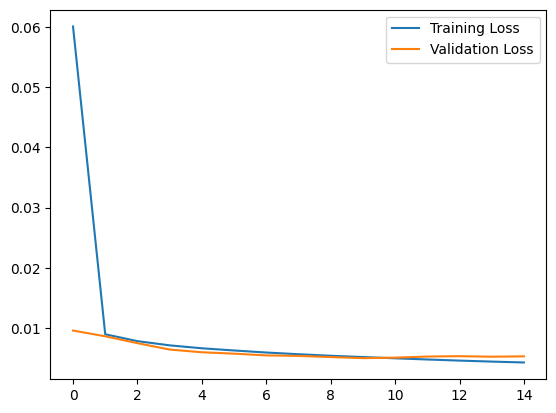

In [73]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

2024-02-08 21:36:19.743123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 1s 5ms/step


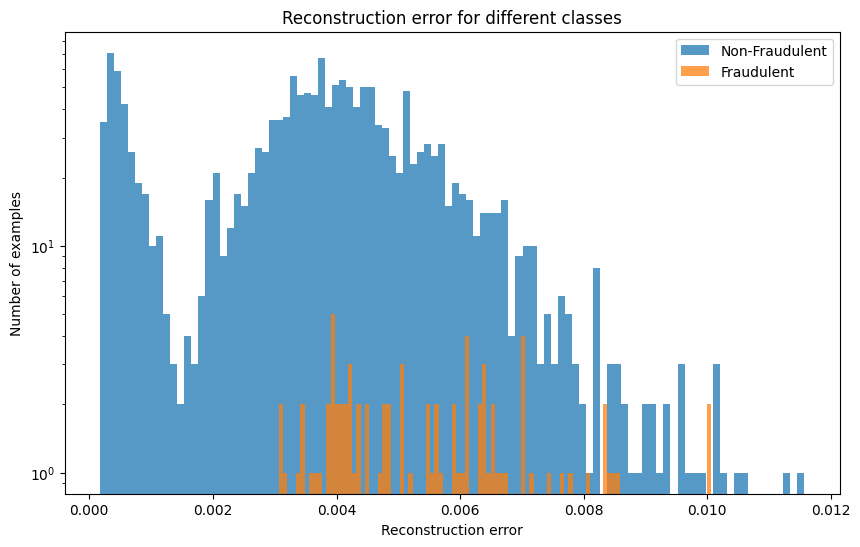

In [74]:
import matplotlib.pyplot as plt
import numpy as np

autoencoder = best_model

# Predict the reconstructions for the validation set
reconstructions = autoencoder.predict(validation_data_scaled)

# Calculate the mean squared error for each sample
mse = np.mean(np.power(validation_data_scaled - reconstructions, 2), axis=1)
mse.shape

# Create a DataFrame for ease of operation
mse_df = pd.DataFrame({'Reconstruction_Error': mse,
                       'True_Class': valid_y.values})

# Separate the errors based on fraudulent and non-fraudulent
false_positives = mse_df[(mse_df['True_Class'] == 1)]
true_negatives = mse_df[(mse_df['True_Class'] == 0)]

# Plot the histograms
plt.figure(figsize=(10, 6))

plt.hist(true_negatives['Reconstruction_Error'], bins=100, alpha=0.75, label='Non-Fraudulent')
plt.hist(false_positives['Reconstruction_Error'], bins=100, alpha=0.75, label='Fraudulent')

plt.xlabel('Reconstruction error')
plt.ylabel('Number of examples')
plt.yscale('log') # The log scale is used because of the skewness of error distribution
plt.title('Reconstruction error for different classes')
plt.legend()
plt.show()


In [75]:
from sklearn.metrics import mean_squared_error, precision_score, recall_score, classification_report

# Predict the reconstructions from the autoencoder
reconstructions = autoencoder.predict(test_data_scaled)

# Calculate the mean squared error between the reconstructions and the original data
mse = np.mean(np.square(reconstructions - test_data_scaled), axis=1)

# Set a threshold for your anomaly scores above which an instance is considered abnormal
# threshold = np.quantile(mse, 0.95)  # you might want to adjust this value

threshold = np.mean(mse) + np.std(mse)
print("Threshold: ", threshold)

# Compute the anomaly score - binary vector
pred_y = mse > threshold

# True labels (assuming you have a 'Fraud' column in your test_data)
true_y = test_y

# Calculate precision and recall
precision = precision_score(true_y, pred_y)
recall = recall_score(true_y, pred_y)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

# For a more comprehensive report, you can use:
print(classification_report(true_y, pred_y))


2024-02-08 21:36:20.813112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 1s 10ms/step
Threshold:  0.005886385499684196
Precision: 0.0603448275862069
Recall: 0.4
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1713
           1       0.06      0.40      0.10        35

    accuracy                           0.86      1748
   macro avg       0.52      0.64      0.52      1748
weighted avg       0.97      0.86      0.91      1748



55/55 [==============================] - 0s 5ms/step


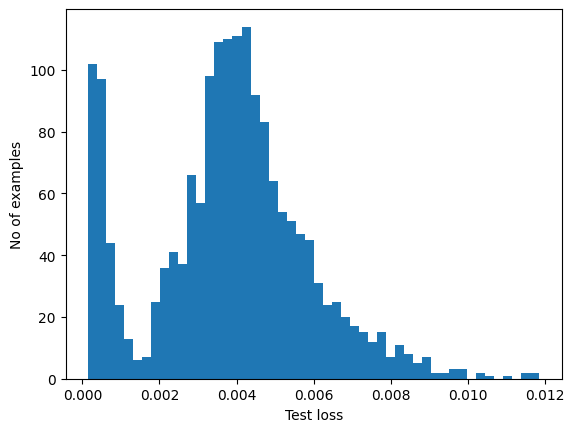

In [76]:
reconstructions = autoencoder.predict(test_data_scaled)
test_loss = tf.keras.losses.mse(reconstructions, test_data_scaled)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()


In [77]:
def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mse(reconstructions, data)
    return tf.math.less(loss, threshold)


def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Hit rate = {}".format(precision_score(labels, predictions)))

    print("Detection rate = {}".format(recall_score(labels, predictions)))

In [78]:
preds = predict(autoencoder, test_data_scaled, threshold)
print_stats(pred_y, test_y)

55/55 [==============================] - 0s 5ms/step
Accuracy = 0.8632723112128147
Hit rate = 0.0603448275862069
Detection rate = 0.4
